In [ ]:
#Libraries Used
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import cv2
from google.colab.patches import cv2_imshow
import math
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
!pip install ffmpeg
import ffmpeg

In [ ]:
#Dataset used
!unzip with_mask.zip with_mask
!unzip without_mask.zip without_mask

In [ ]:
#PARAMETERS

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
imagePaths = ["/content/with_mask/","/content/without_mask/"]
data = []
labels = []

#IMAGE LOADING
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-1]
  print(label)
  for i in os.listdir(imagePath):
    j=imagePath+i
    if j!="/content/with_mask/.DS_Store" and j!="/content/without_mask/.DS_Store":
      image = load_img(j, target_size=(224, 224))
      image = img_to_array(image)
      image = preprocess_input(image)
      data.append(image)
      labels.append(label)
print(len(data),len(labels))


#DATA TRANSFORMATION
data = np.array(data, dtype="float32")
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#DATA SPLITING
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

#DATA AUGMENTATION
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

#MODEL
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

#COMPILING
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS),metrics=["accuracy"])
#FITTING
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),validation_steps=len(testX) // BS,epochs=EPOCHS)
#PREDICTING
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

#SAVING MODEL
model.save("model.h5")

In [ ]:
#PLOTTING LOSS AND ACCURACY
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
#MODEL LOADING
model = load_model("/content/drive/My Drive/dataset face mask/mask_detector.model")
net = cv2.dnn.readNet("/content/drive/My Drive/dataset face mask/deploy.prototxt","/content/drive/My Drive/dataset face mask/res10_300x300_ssd_iter_140000.caffemodel")

In [ ]:
fake_image=cv2.imread("/content/drive/My Drive/dataset face mask/GettyImages-1207592068-crop-650aaba.jpg")
print(fake_image.shape[:2])

(414, 620)


In [ ]:
#IMAGE PREDICTION FUNCTION
def imagepred(filename):
  image = cv2.imread(filename)
  orig = image.copy()
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
      (mask, withoutMask) = model.predict(face)[0]
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  cv2.imwrite(filename,image)
  cv2_imshow(image)

In [ ]:
#VIDEO FUNCTION
def videopred(filename):
  image = cv2.imread('img/'+filename)
  orig = image.copy()
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
      (mask, withoutMask) = model.predict(face)[0]
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
      cv2.putText(image, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  cv2.imwrite('outputimg/'+filename,image)

In [ ]:
#For Video Feed and prediction
def video():
  !mkdir 'img'
  !mkdir 'outputimg'
  ! ffmpeg -i /content/Coronavirus_01_4k_013.mp4 -vf fps=1 img/output%06d.jpg -loglevel quiet
  lst=[]
  lst=os.listdir('img')
  lst.sort()
  for i in lst:
    if '.jpg' in i:videopred(i)
  ! ffmpeg -r 1 -f image2 -s 1920x1080 -i outputimg/output%06d.jpg -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4 -loglevel quiet
  print("VIDEO SAVED")
  !rm -rf img
  !rm -rf outputimg
  print("Extra Files Removed")

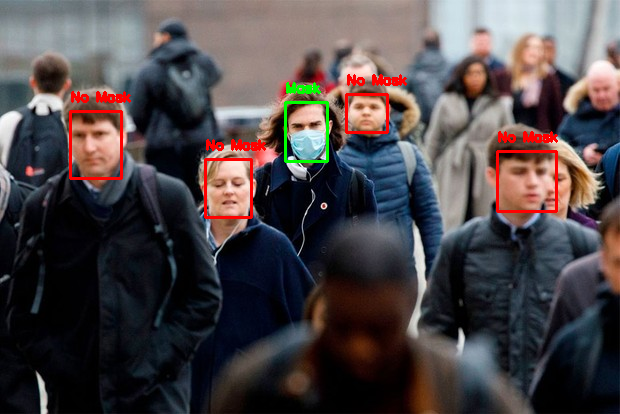

In [ ]:
imagepred('GettyImages-1207592068-crop-650aaba.jpg')

In [ ]:
video()

VIDEO SAVED
Extra Files Removed
